In [22]:
!conda info | grep 'active env'

     active environment : findtime
    active env location : /home/jpartanen/mambaforge/envs/findtime


In [23]:
import geopandas as gpd
import geoplot as gplt
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sqlite3
from OSMPythonTools.overpass import Overpass, overpassQueryBuilder
from pathlib import Path
from shapely import wkt
from shapely.geometry import Point, Polygon, MultiPolygon

In [24]:
all_element_types = ['node', 'way', 'relation', 'area']

built_area_tags = [
    ('landuse', 'residential'),
    ('landuse', 'commercial'),
    ('landuse', 'industrial'),
    ('landuse', 'retail'),
    ('landuse', 'institutional'),
    ('landuse', 'education'),
    ('landuse', 'civil'),
    ('place', 'city_block'),
    ('building', '*'),
]

human_crs = 'EPSG:4326'
processing_crs = 'EPSG:3857'

In [25]:
# !wget http://download.geofabrik.de/europe/finland-latest.osm.pbf

In [26]:
# !ogr2ogr -f SQLite -lco FORMAT=WKT finland.sqlite finland-latest.osm.pbf

In [27]:
finland_osm_filepath = "finland.sqlite"
feather_filepath = "finland_osm.feather"
helsinki_feather_filepath = "helsinki_osm.feather"

con = sqlite3.connect(finland_osm_filepath)

In [28]:
if not Path(feather_filepath).is_file():
  finland_osm_df = pd.DataFrame()
  geom_types = ['lines', 'multilinestrings', 'multipolygons', 'other_relations']
  for geom_type in geom_types:
    print(f"Processing '{geom_type}'...")
    df = pd.read_sql(f"SELECT *, '{geom_type}' AS table_name FROM {geom_type};", con)
    finland_osm_df = pd.concat([finland_osm_df, df], ignore_index=True)

  finland_osm_df.info()

  # convert dataframe into geodataframe
  finland_osm_df['geom'] = gpd.GeoSeries.from_wkt(finland_osm_df['WKT_GEOMETRY'])
  finland_osm_gdf = gpd.GeoDataFrame(finland_osm_df, geometry='geom', crs=human_crs)
  finland_osm_gdf.info()

  finland_osm_gdf.to_feather(feather_filepath)

In [29]:
small_patch_of_Helsinki = (24.904289,60.178148,24.957504,60.194364)
bbox = small_patch_of_Helsinki

if Path(helsinki_feather_filepath).is_file():
    print("Loading helsinki feather")
    finland_osm_gdf = gpd.read_feather(helsinki_feather_filepath)
else:
    print("Loading Finland feather")
    finland_osm_gdf = gpd.read_feather(feather_filepath)
    
    bbox_polygon = Polygon([(bbox[0], bbox[1]), (bbox[0], bbox[3]), (bbox[2], bbox[3]), (bbox[2], bbox[1])])
    bbox_gdf = gpd.GeoDataFrame(geometry=[bbox_polygon], crs=human_crs).to_crs(processing_crs)

    bbox_gdf_bounds = tuple(bbox_gdf.total_bounds)
    bbox_edge_lengths = (bbox_gdf_bounds[2] - bbox_gdf_bounds[0], bbox_gdf_bounds[3] - bbox_gdf_bounds[1])
    bbox_width = min(bbox_edge_lengths)
    bbox_length = max(bbox_edge_lengths)
    buffer_by = 1 * bbox_length
    bbox_gdf = bbox_gdf.buffer(buffer_by).to_crs(human_crs)
    
    finland_osm_fix = finland_osm_gdf.buffer(0)
    finland_osm_fix = finland_osm_fix.make_valid()
    finland_osm_gdf['geometry'] = gpd.clip(finland_osm_fix, mask=bbox_gdf)
    
    finland_osm_gdf.to_feather(helsinki_feather_filepath)

Loading helsinki feather


In [30]:
osm_keys = list(set(a for a, b in built_area_tags))
other_columns_to_keep = ['table_name', 'geom']
columns_to_keep = osm_keys + other_columns_to_keep
print(f"before: {finland_osm_gdf.columns}")
finland_osm_gdf = finland_osm_gdf[columns_to_keep]
print(type(finland_osm_gdf))
print(finland_osm_gdf.info())

before: Index(['ogc_fid', 'WKT_GEOMETRY', 'osm_id', 'name', 'highway', 'waterway',
       'aerialway', 'barrier', 'man_made', 'z_order', 'other_tags',
       'table_name', 'type', 'osm_way_id', 'aeroway', 'amenity', 'admin_level',
       'boundary', 'building', 'craft', 'geological', 'historic', 'land_area',
       'landuse', 'leisure', 'military', 'natural', 'office', 'place', 'shop',
       'sport', 'tourism', 'geom', 'geometry'],
      dtype='object')
<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5123203 entries, 0 to 5123202
Data columns (total 5 columns):
 #   Column      Dtype   
---  ------      -----   
 0   landuse     object  
 1   place       object  
 2   building    object  
 3   table_name  object  
 4   geom        geometry
dtypes: geometry(1), object(4)
memory usage: 195.4+ MB
None


<Axes: >

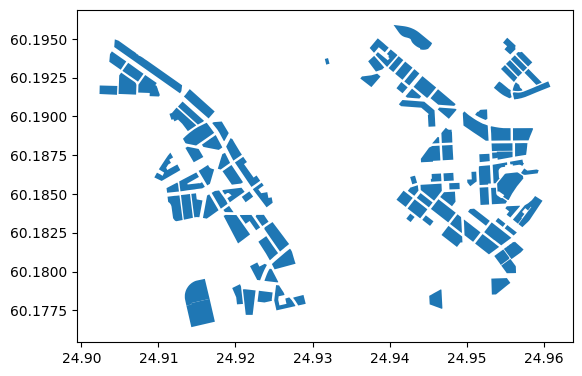

In [31]:
helsinki_metro_area = (24.904289,60.178148,24.957504,60.194364)
helsinki_polygon = Polygon([(24.904289,60.178148), (24.904289,60.194364), (24.957504,60.194364), (24.957504,60.178148)])
finland_osm_gdf[(finland_osm_gdf["table_name"] == "multipolygons") & (finland_osm_gdf["landuse"].notnull())].head()

# landuse == residential in Helsinki metro area
helsinki_residential_gdf = finland_osm_gdf[(finland_osm_gdf["table_name"] == "multipolygons") & (finland_osm_gdf["landuse"] == "residential") & (finland_osm_gdf.intersects(helsinki_polygon))]
helsinki_residential_gdf.plot()

In [32]:
# Load Finland as a polygon
world_filepath = gpd.datasets.get_path('naturalearth_lowres')
world = gpd.read_file(world_filepath)
finland_polygon = world[world.name == "Finland"].geometry.values[0]

/tmp/ipykernel_143814/812973673.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world_filepath = gpd.datasets.get_path('naturalearth_lowres')


In [33]:
def get_sampled_points(count, mean, crs, cov=None) -> gpd.GeoDataFrame:
    if cov is None:
        cov = [[6e6, 4e6], [4e6, 3.5e6]]
    # cov = np.array([[6, -3], [-3, 3.5]])
    points = np.random.multivariate_normal(mean, cov, size=count)
    points_gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(points[:, 0], points[:, 1]), crs=crs)
    return points_gdf

In [34]:
from matplotlib.axes import Axes
from matplotlib.collections import PathCollection
from matplotlib.path import Path

def polygons_from_kde(kde: Axes) -> list[MultiPolygon]:
    # Adapted from https://gist.github.com/haavardaagesen/96f5566a06b83648f393d00a0aa5bd48#file-contours_to_polygons-py
    polygons: list[MultiPolygon] = []
    for col in kde.collections:
        if not isinstance(col, PathCollection):
            continue
        polys = []
        # Loop through all polygons that have the same intensity level
        for contour in col.get_paths(): 
            if not isinstance(contour, Path):
                continue
            # Create a polygon for the countour
            # First polygon is the main countour, the rest are holes
            for _, points in enumerate(contour.to_polygons(closed_only=True)):
                x = points[:,0]
                y = points[:,1]
                poly = Polygon([(i[0], i[1]) for i in zip(x,y)])
                # Append polygon to list
                polygons.append(poly)
    return polygons

In [35]:
# random points in Finland
n = 10
dist_mean_points: list[Point] = []


while len(dist_mean_points) < n:
    # generate random point in Finland
    x = np.random.uniform(bbox[0], bbox[2])
    y = np.random.uniform(bbox[1], bbox[3])
    point = Point(x, y)
    if finland_polygon.contains(point):
        dist_mean_points.append(point)

dist_mean_points

[<POINT (24.919 60.186)>,
 <POINT (24.905 60.193)>,
 <POINT (24.954 60.188)>,
 <POINT (24.938 60.179)>,
 <POINT (24.912 60.181)>,
 <POINT (24.952 60.194)>,
 <POINT (24.93 60.179)>,
 <POINT (24.945 60.181)>,
 <POINT (24.917 60.184)>,
 <POINT (24.92 60.187)>]

(2773944.629736558, 8441337.549601201)
[2765481.34846772 8436096.19764029 2782266.11560442 8448066.38122552]
width and height: 16784.767136708368, 11970.183585235849


(2772381.694405111, 8442880.459346335)
[2764662.1876544  8436223.96955372 2778788.52775188 8447603.63323869]
width and height: 14126.340097484179, 11379.663684967905
(2777814.5615457916, 8441734.064228984)
[2770690.87585897 8435676.00355762 2783830.76151934 8446890.56656932]
width and height: 13139.885660365224, 11214.563011707738
(2776081.9051776193, 8439658.741859643)
[2768177.24198406 8433040.01565851 2784710.03452118 8444859.83261081]
width and height: 16532.792537113186, 11819.816952306777
(2773185.017373035, 8440205.744413571)
[2764853.05959184 8434588.17901523 2779915.57073154 8445771.79302022]
width and height: 15062.511139705777, 11183.614004993811
(2777630.2264949153, 8442951.392360248)
[2770848.68557648 8437738.52185952 2784048.90253147 8447956.55831202]
width and height: 13200.216954987496, 10218.036452496424
(2775193.473703735, 8439679.712829653)
[2768994.74102029 8435128.62009178 2782327.5859428  8445126.3215402 ]
width and height: 13332.844922503456, 9997.701448423788
(2

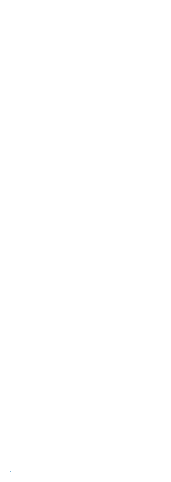

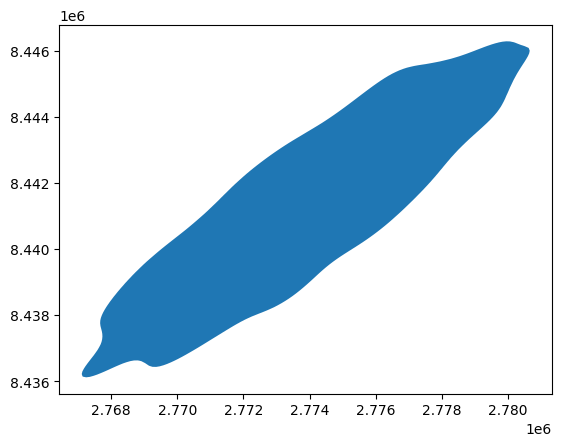

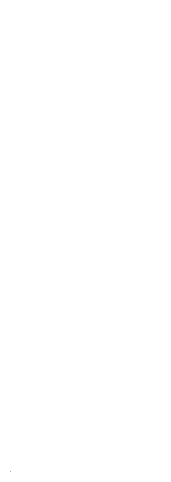

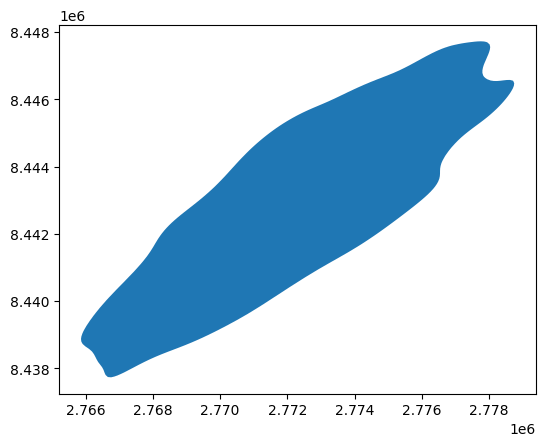

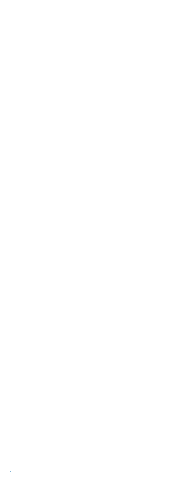

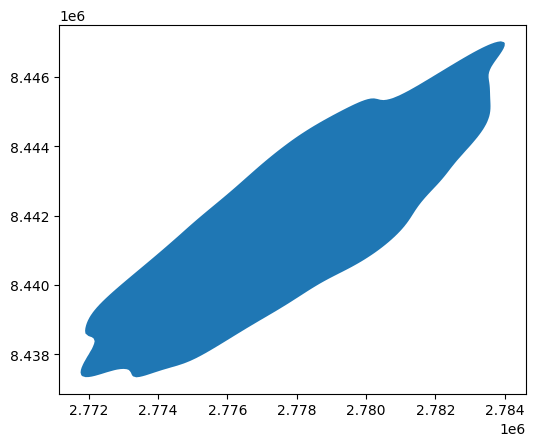

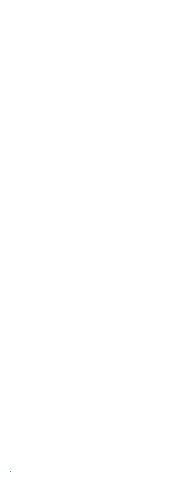

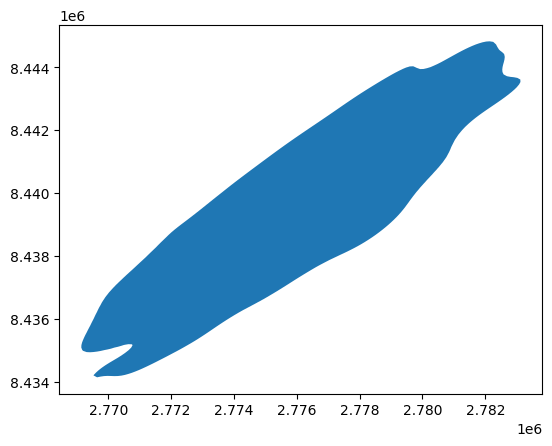

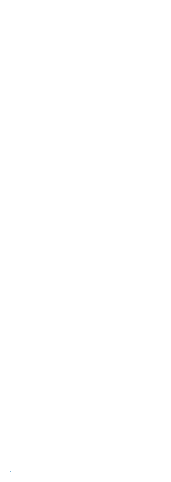

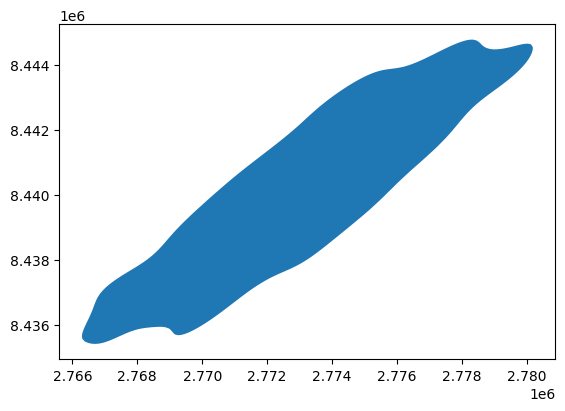

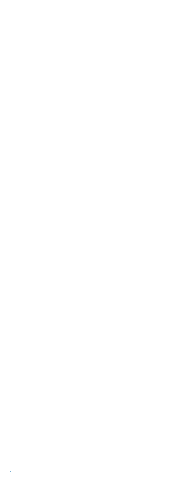

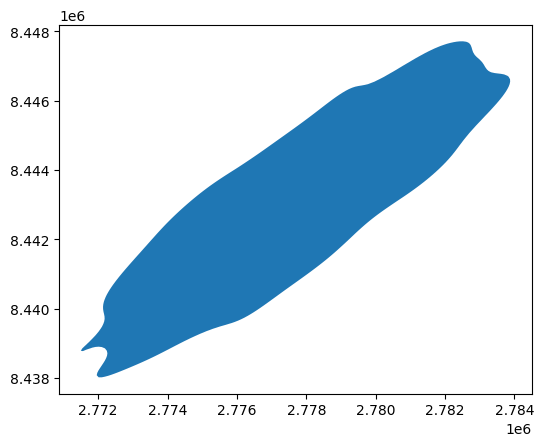

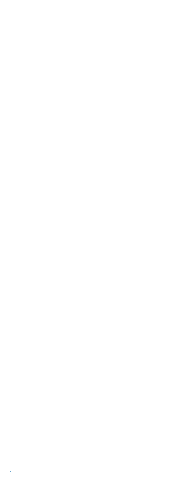

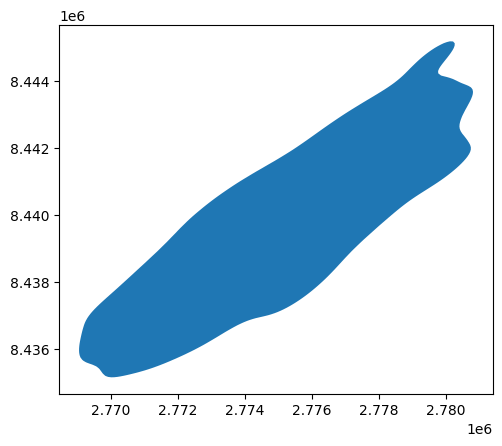

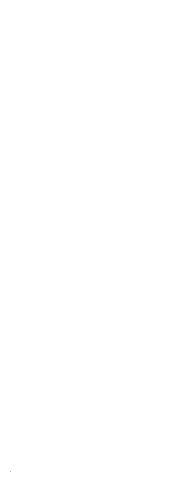

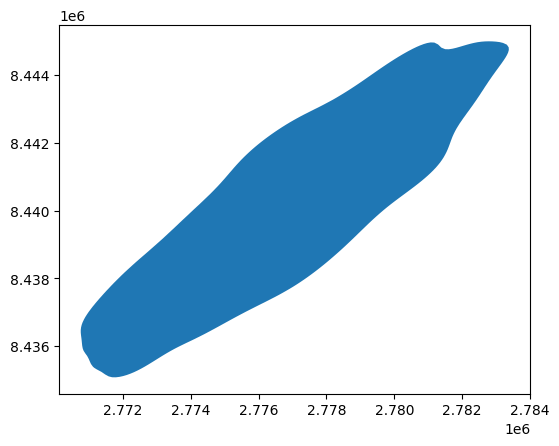

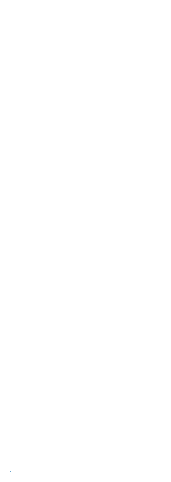

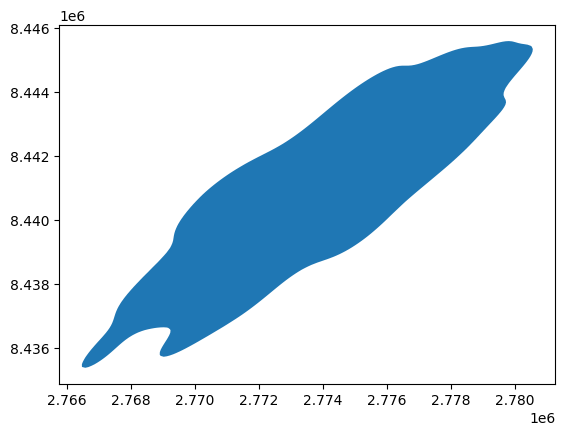

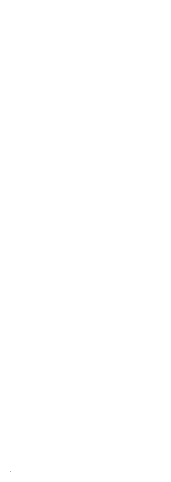

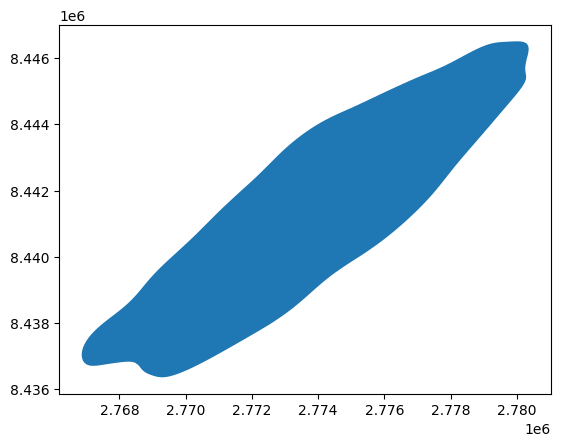

In [36]:
# for each mean, sample 1000 points
# then get the KDE
# get the KDE outermost contour as a polygon

proportion_of_distribution = 0.05
levels = [proportion_of_distribution]

sample_count = 500

landings_kde_poly_gdfs = []
for mean in dist_mean_points:
    mean_point = Point(mean.x, mean.y)
    mean_in_processing_crs = gpd.GeoDataFrame(geometry=[mean_point], crs=human_crs).to_crs(processing_crs).geometry.values[0].coords[0]
    print(mean_in_processing_crs)
    sampled_points_gdf = get_sampled_points(count=sample_count, mean=mean_in_processing_crs, crs=processing_crs)
    print(sampled_points_gdf.total_bounds)
    print(f"width and height: {sampled_points_gdf.total_bounds[2] - sampled_points_gdf.total_bounds[0]}, {sampled_points_gdf.total_bounds[3] - sampled_points_gdf.total_bounds[1]}")
    kde = gplt.kdeplot(sampled_points_gdf, levels=levels)
    polys = polygons_from_kde(kde)
    poly_gdf = gpd.GeoDataFrame(geometry=polys, crs=processing_crs)
    landings_kde_poly_gdfs.append(poly_gdf)
    poly_gdf.plot()

In [37]:
def proportion_of_kde_built_area(kde_poly, built_areas):
    intersection = kde_poly.intersection(built_areas)
    return intersection.area / kde_poly.area

geometry_types_of_interest = ['multipolygons', 'polygons', 'other_relations']

conditions = None
for key, val in built_area_tags:
    cond = finland_osm_gdf[key] == val
    if conditions is None:
        conditions = cond
    else:
        conditions = conditions | cond
conditions = (conditions) & finland_osm_gdf["table_name"].isin(geometry_types_of_interest)
print(finland_osm_gdf[conditions])

"""
interesting_finland_osm_gdf = finland_osm_gdf[conditions].to_crs(processing_crs)
interesting_finland_osm_gdf = interesting_finland_osm_gdf.make_valid()
print(f"total bounds valid: {interesting_finland_osm_gdf.total_bounds}")
print("made valid")
interesting_finland_osm_gdf = interesting_finland_osm_gdf.buffer(0)
print(f"total bounds buffered: {interesting_finland_osm_gdf.total_bounds}")
print("extra fix with small buffer")
"""
interesting_finland_osm_union_gdf = gpd.GeoDataFrame(geometry=[interesting_finland_osm_gdf.unary_union], crs=interesting_finland_osm_gdf.crs)
print(f"total bounds unioned: {interesting_finland_osm_union_gdf.total_bounds}")
print("finland osm unioned")


             landuse place building     table_name   
3094089  residential  None     None  multipolygons  \
3094342  residential  None     None  multipolygons   
3094724  residential  None     None  multipolygons   
3095608  residential  None     None  multipolygons   
3095678   industrial  None     None  multipolygons   
...              ...   ...      ...            ...   
5110873   industrial  None     None  multipolygons   
5110874  residential  None     None  multipolygons   
5110875  residential  None     None  multipolygons   
5110876  residential  None     None  multipolygons   
5110883  residential  None     None  multipolygons   

                                                      geom  
3094089  MULTIPOLYGON (((25.09702 60.45602, 25.09709 60...  
3094342  MULTIPOLYGON (((24.68185 60.19660, 24.68132 60...  
3094724  MULTIPOLYGON (((25.05553 60.16164, 25.05516 60...  
3095608  MULTIPOLYGON (((24.78789 60.16329, 24.78890 60...  
3095678  MULTIPOLYGON (((21.66073 63.08253, 21

In [38]:
print(interesting_finland_osm_union_gdf.total_bounds)

[ 2179357.9320306   8357212.58616796  3483246.12238647 11095184.43911261]


number of vertices: 505
number of vertices: 535
number of vertices: 537
number of vertices: 555
number of vertices: 531
number of vertices: 555
number of vertices: 563
number of vertices: 499
number of vertices: 593
number of vertices: 505


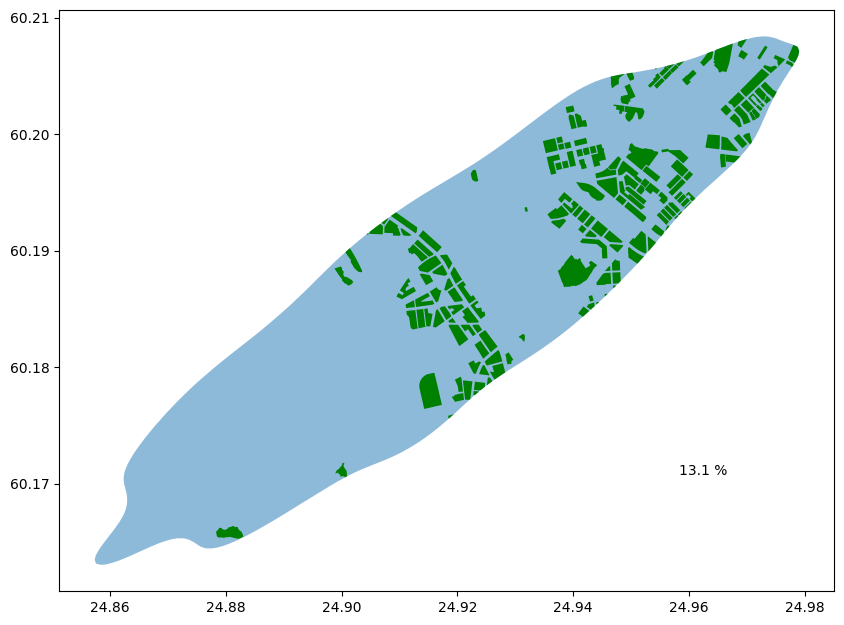

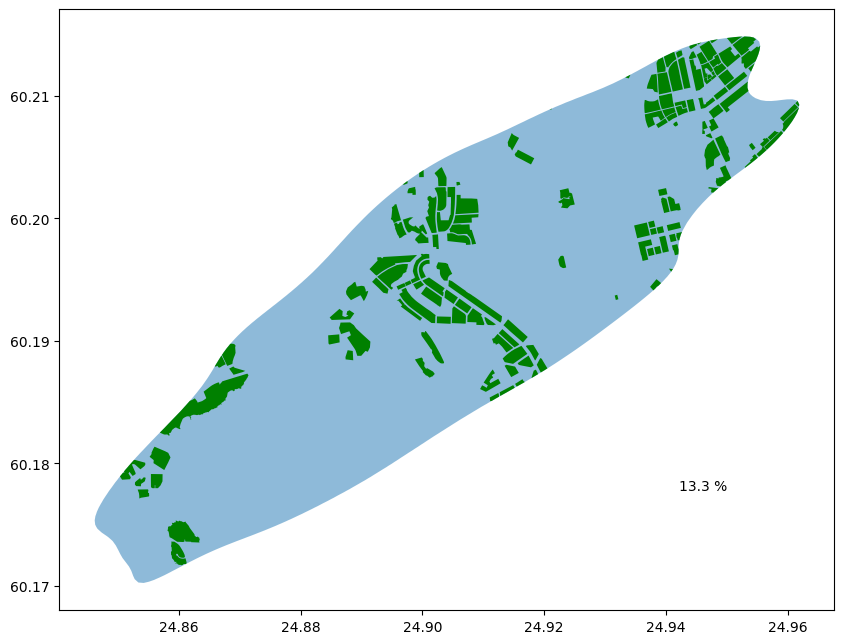

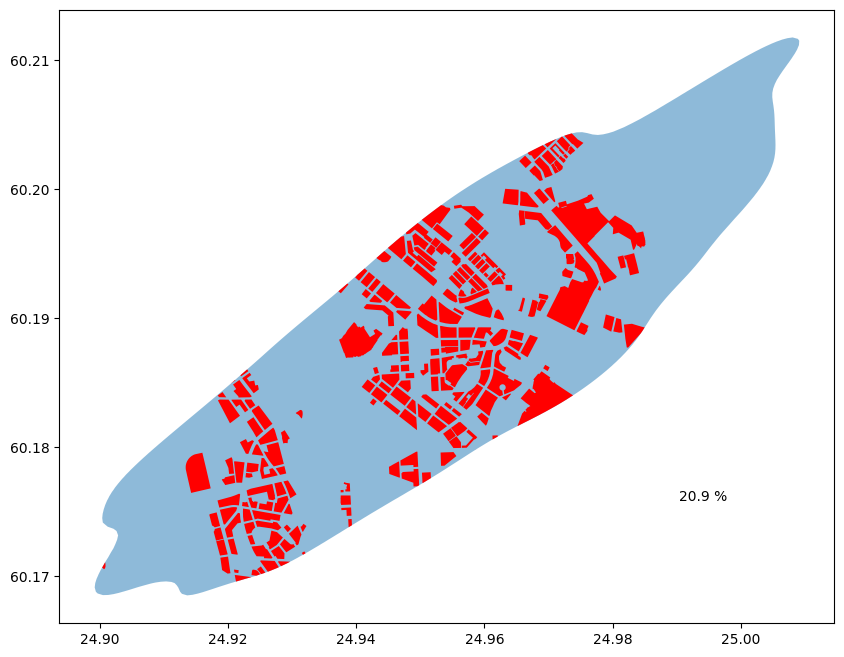

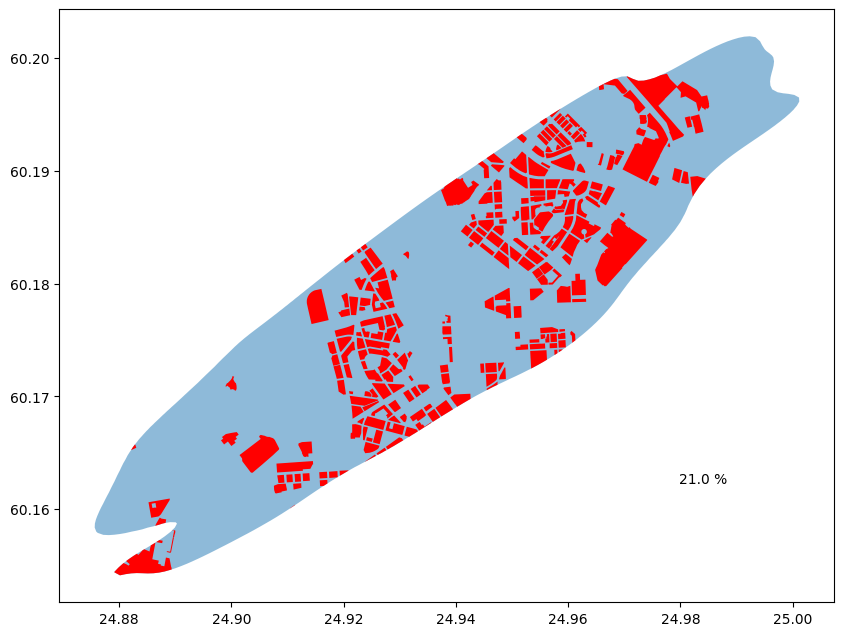

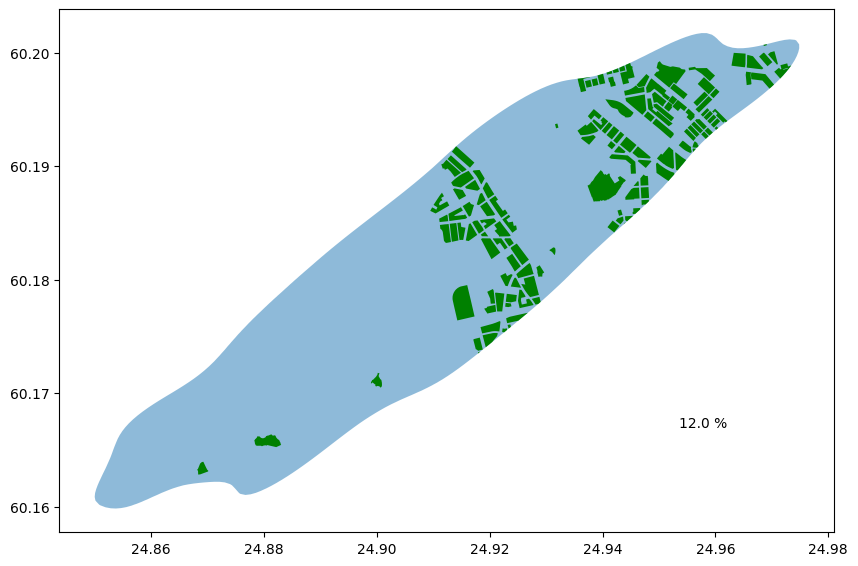

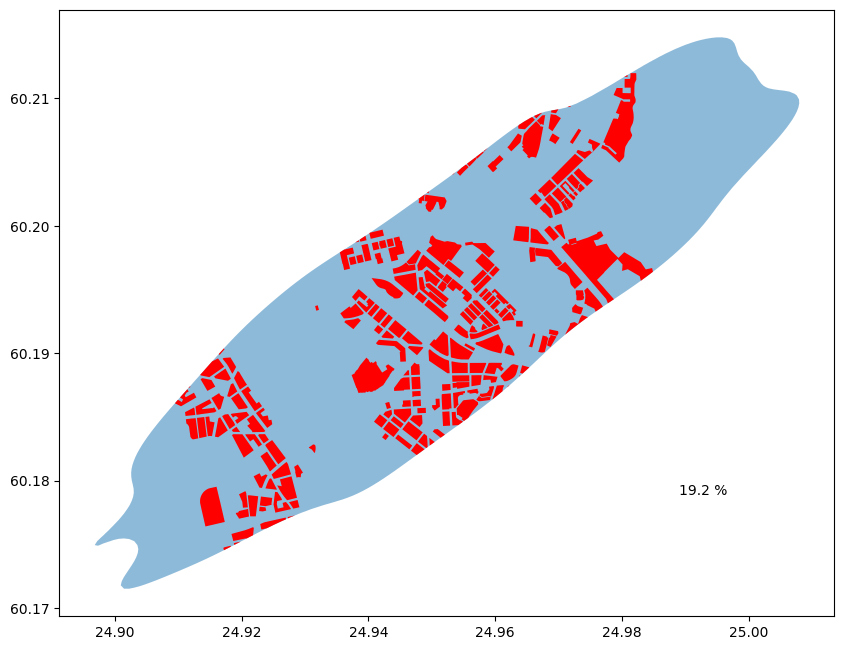

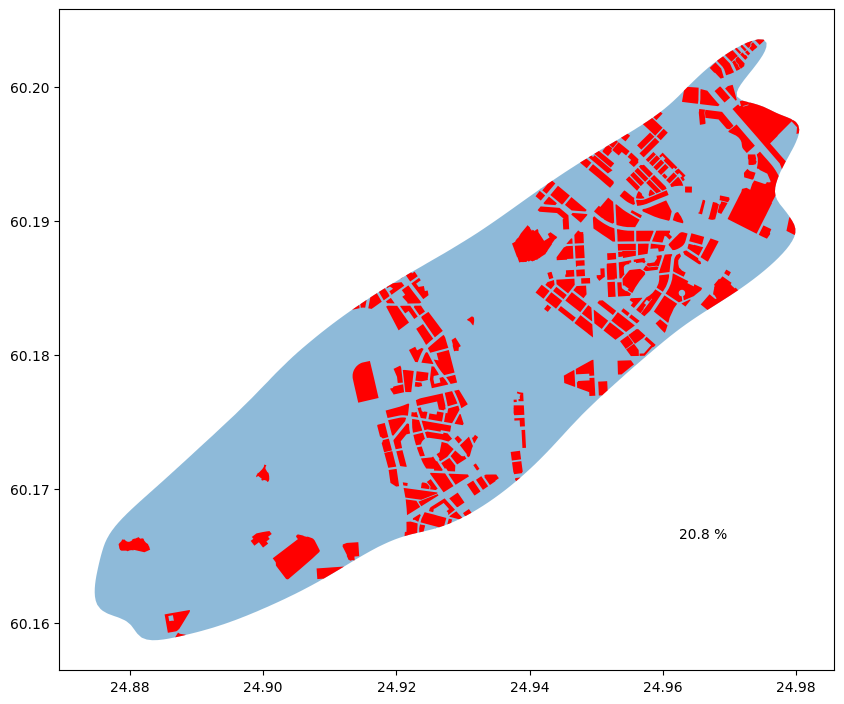

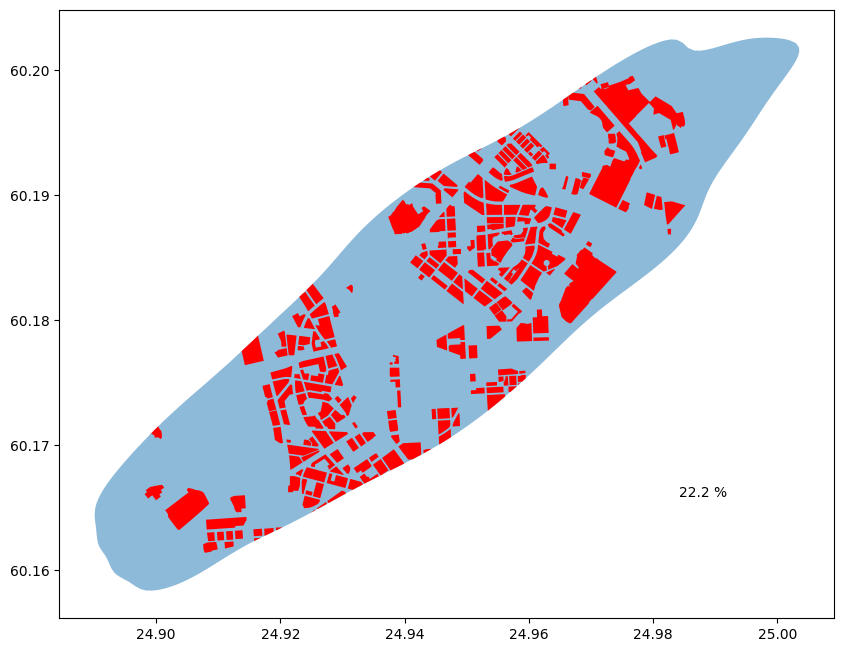

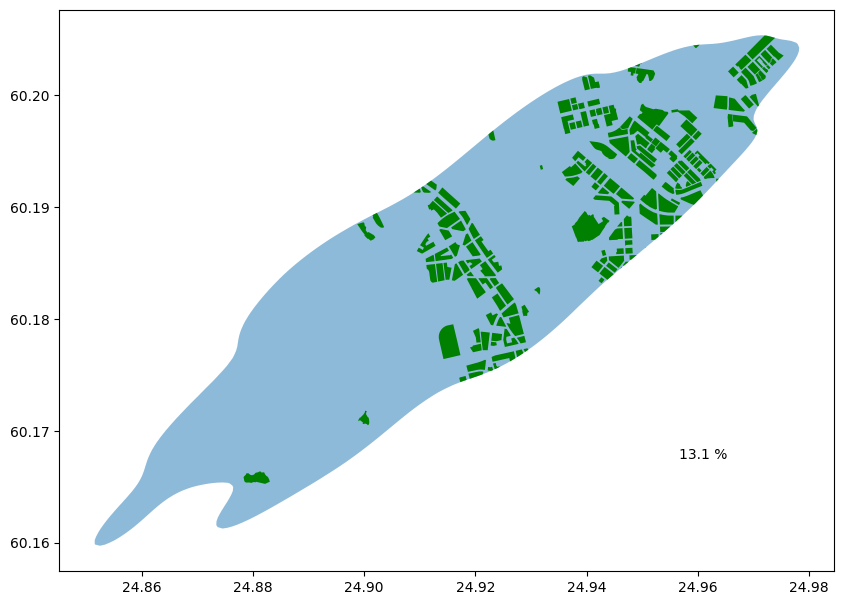

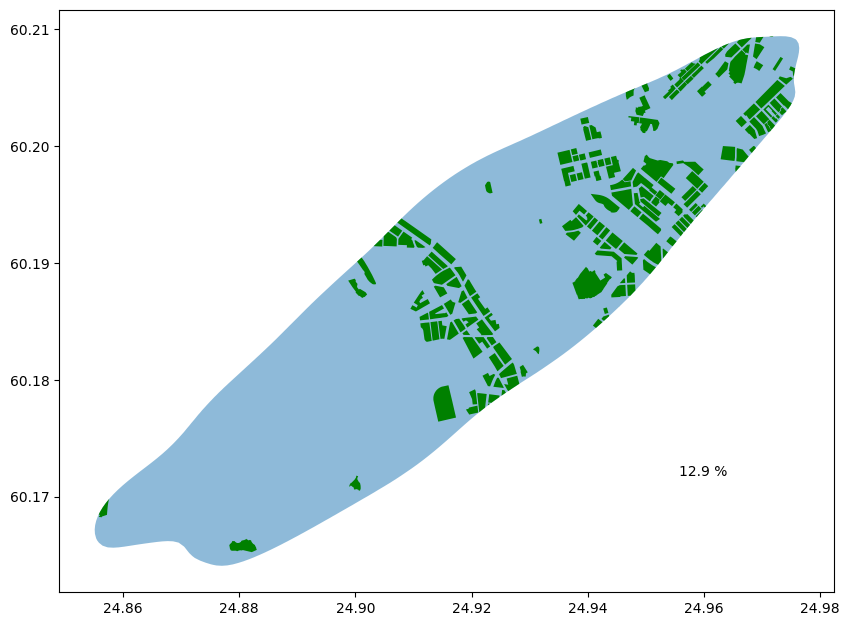

In [41]:
def get_the_single_polygon(gdf: gpd.GeoDataFrame):
    geoms = gdf.geometry
    if len(geoms) == 1:
        return geoms[0]
    else:
        raise RuntimeError("This shouldn't be happening")

def intersecting_built_area(kde_poly_gdf):
    kde_union_gdf = gpd.GeoDataFrame(geometry=[kde_poly_gdf.unary_union], crs=kde_poly_gdf.crs).to_crs(interesting_finland_osm_union_gdf.crs)
    kde_multipoly = get_the_single_polygon(kde_union_gdf)
    print(f"number of vertices: {len(kde_multipoly.exterior.coords)}")
    finland_multipoly = get_the_single_polygon(interesting_finland_osm_union_gdf)
    # print(kde_union_gdf.total_bounds)
    # print(interesting_finland_osm_union_gdf.total_bounds)
    if not kde_multipoly.intersects(finland_multipoly):
        return None
    intersection = kde_multipoly.intersection(finland_multipoly)
    return gpd.GeoDataFrame(geometry=[intersection], crs=kde_union_gdf.crs)

max_proportion = 0.15

interesting_finland_osm_union_gdf = interesting_finland_osm_union_gdf.to_crs(processing_crs)
for poly_gdf in landings_kde_poly_gdfs:
    built_area = intersecting_built_area(poly_gdf)
    proportion_of_built_area_to_whole = built_area.area.sum() / poly_gdf.area.sum() if built_area is not None else 0
    if proportion_of_built_area_to_whole < max_proportion:
        built_area_color = 'green'
    else:
        built_area_color = 'red'
    # plot the intersection on top of the kde
    kde_ax = poly_gdf.to_crs(human_crs).plot(alpha=0.5, figsize=(10, 10))
    if built_area is not None:
        # no intersection
        built_area.to_crs(human_crs).plot(ax=kde_ax, color=built_area_color)
    proportion_in_chart = round(proportion_of_built_area_to_whole*100, 1)
    proportion_text = f"{proportion_in_chart} %"
    plt.text(0.8, 0.2, proportion_text, transform=kde_ax.transAxes)